### Testing network metrics

In [61]:
# Adding GDa to path
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import brainconn as bc
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np

#### Loading adjacency

In [62]:
A = np.loadtxt("data/adjacency.txt")

In [63]:
# Convert to igraph object
g = ig.Graph.Weighted_Adjacency(
    A.tolist(), attr="weight", loops=False, mode=ig.ADJ_UNDIRECTED
)

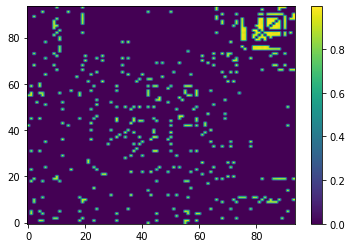

In [64]:
plt.imshow(A, aspect="auto", origin="lower")
plt.colorbar()

#### Nodes distance matrix (Dijkstra)

In [65]:
Dbc, _ = bc.distance.distance_wei(A)

In [66]:
Dig = np.asarray(g.shortest_paths_dijkstra(weights="weight"))

Text(0.5, 1.0, 'igraph')

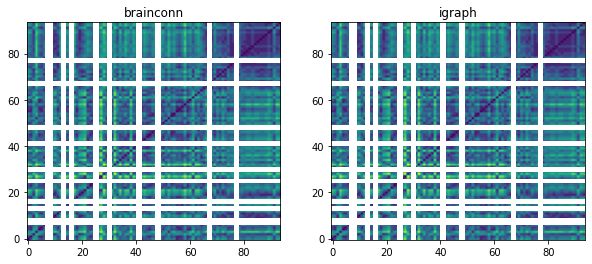

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(Dbc, aspect="auto", origin="lower")
plt.title("brainconn")
plt.subplot(1, 2, 2)
plt.imshow(Dig, aspect="auto", origin="lower")
plt.title("igraph")

#### Efficiency

In [22]:
bc.distance.efficiency_wei(A, True)

array([0.85292658, 0.80487021, 0.77780726, 0.        , 0.59654749,
       0.57753643, 0.7290663 , 0.        , 0.        , 0.81992788,
       0.7503801 , 0.37706499, 0.78800462, 0.        , 0.87107344,
       0.        , 0.        , 0.        , 0.78719581, 0.80291096,
       0.84934453, 0.30160949, 0.33100879, 0.25749978, 0.27206434,
       0.        , 0.85056157, 0.        , 0.        , 0.40850992,
       0.        , 0.79886308, 0.        , 0.78775343, 0.44951282,
       0.77317676, 0.80839658, 0.82229228, 0.        , 0.5306947 ,
       0.24609655, 0.        , 0.54288479, 0.43995529, 0.59957308,
       0.50301101, 0.84415678, 0.87508618, 0.        , 0.46085603,
       0.73313003, 0.80493374, 0.3983905 , 0.33701261, 0.93339787,
       0.76817694, 0.75729572, 0.27020925, 0.        , 0.76735048,
       0.        , 0.51256288, 0.        , 0.29169539, 0.73748752,
       0.74729051, 0.83447524, 0.        , 0.7937581 , 0.28676799,
       0.51380111, 0.74271636, 0.75931659, 0.60845647, 0.82641

In [23]:
def cuberoot(x):
    """
    Correctly handle the cube root for negative weights, instead of uselessly
    crashing as in python or returning the wrong root as in matlab
    """
    return np.sign(x) * np.abs(x) ** (1 / 3)


def invert(W, copy=True):
    """
    Inverts elementwise the weights in an input connection matrix.
    In other words, change the from the matrix of internode strengths to the
    matrix of internode distances.
    If copy is not set, this function will *modify W in place.*
    Parameters
    ----------
    W : :obj:`numpy.ndarray`
        weighted connectivity matrix
    copy : bool
        if True, returns a copy of the matrix. Otherwise, modifies the matrix
        in place. Default value=True.
    Returns
    -------
    W : :obj:`numpy.ndarray`
        inverted connectivity matrix
    """
    if copy:
        W = W.copy()
    E = np.where(W)
    W[E] = 1.0 / W[E]
    return W


def distance_inv_wei(G):
    n = len(G)
    D = np.zeros((n, n))  # distance matrix
    D[np.logical_not(np.eye(n))] = np.inf

    for u in range(n):
        # distance permanence (true is temporary)
        S = np.ones((n,), dtype=bool)
        G1 = G.copy()
        V = [u]
        while True:
            S[V] = 0  # distance u->V is now permanent
            G1[:, V] = 0  # no in-edges as already shortest
            for v in V:
                (W,) = np.where(G1[v, :])  # neighbors of smallest nodes
                td = np.array([D[u, W].flatten(), (D[u, v] + G1[v, W]).flatten()])
                D[u, W] = np.min(td, axis=0)

            if D[u, S].size == 0:  # all nodes reached
                break
            minD = np.min(D[u, S])
            if np.isinf(minD):  # some nodes cannot be reached
                break
            (V,) = np.where(D[u, :] == minD)

    np.fill_diagonal(D, 1)
    D = 1 / D
    np.fill_diagonal(D, 0)
    return D


def distance_inv(g):
    D = np.asarray(g.shortest_paths_dijkstra(weights="weight"))
    np.fill_diagonal(D, 1)
    D = 1 / D
    np.fill_diagonal(D, 0)
    return D

In [24]:
Gw = A.copy()

In [31]:
def local_efficiency(Gw):
    n = len(Gw)
    Gl = invert(Gw, copy=True)  # connection length matrix
    A = np.array((Gw != 0), dtype=int)

    E = np.zeros((n,))  # local efficiency
    for u in range(n):
        # find pairs of neighbors
        (V,) = np.where(np.logical_or(Gw[u, :], Gw[:, u].T))
        # symmetrized vector of weights
        sw = cuberoot(Gw[u, V]) + cuberoot(Gw[V, u].T)
        if Gl[np.ix_(V, V)].sum() == 0.0:
            E[u] = 0
            continue
        else:
            g = ig.Graph.Weighted_Adjacency(
                Gl[np.ix_(V, V)].tolist(),
                attr="weight",
                loops=False,
                mode=ig.ADJ_UNDIRECTED,
            )
        # inverse distance matrix
        e = distance_inv(g)
        # symmetrized inverse distance matrix
        se = cuberoot(e) + cuberoot(e.T)

        numer = np.sum(np.outer(sw.T, sw) * se) / 2
        if numer != 0:
            # symmetrized adjacency vector
            sa = A[u, V] + A[V, u].T
            denom = np.sum(sa) ** 2 - np.sum(sa * sa)
            # print numer,denom
            E[u] = numer / denom  # local efficiency
    return E

In [37]:
%timeit -n 100 bc.distance.efficiency_wei(A, True)

55 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
%timeit -n 100 local_efficiency(Gw)

6.56 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [177]:
bc.utils.matrix.invert

<function brainconn.utils.matrix.invert(W, copy=True)>

In [83]:
g = ig.Graph.Weighted_Adjacency(
    invert(A).tolist(), attr="weight", loops=False, mode=ig.ADJ_UNDIRECTED
)

In [84]:
d = distance_inv(g)

In [85]:
n = len(A)

In [86]:
np.sum(d) / (n * n - n)

0.22549689178595056

In [38]:
bct_funcs = {
    "clustering": {False: bc.clustering.clustering_coef_bu, True: bc.clustering.clustering_coef_wu}
}


In [84]:
bct_funcs = {}

bct_funcs["clustering"] = {
    False: raise ValueError,
    True: bc.clustering.clustering_coef_wu
}


SyntaxError: invalid syntax (977838406.py, line 4)

In [46]:
bct_funcs["clustering"]

{False: <function brainconn.clustering.clustering.clustering_coef_bu(G)>,
 True: <function brainconn.clustering.clustering.clustering_coef_wu(W)>}

In [50]:
ig.clustering(g)

TypeError: 'module' object is not callable

In [52]:
import numba as nb
@nb.jit(nopython=True)
def _degree(A):
    """ Compute the degree from and adjacency matrix """
    return A.sum(-1)

In [68]:
bc.clustering.clustering_coef_wu(A)

array([0.85292658, 0.47359324, 0.41620309, 0.        , 0.42885402,
       0.41205773, 0.34501494, 0.        , 0.        , 0.52957841,
       0.35045284, 0.34053396, 0.44457502, 0.        , 0.87107344,
       0.        , 0.        , 0.        , 0.521057  , 0.4373758 ,
       0.60686929, 0.30160949, 0.23807744, 0.25749978, 0.20647175,
       0.        , 0.61396204, 0.        , 0.        , 0.29324795,
       0.        , 0.45184139, 0.        , 0.44873857, 0.44951282,
       0.44166993, 0.45717782, 0.54417188, 0.        , 0.45856874,
       0.17730556, 0.        , 0.21619381, 0.31626545, 0.43013639,
       0.27733667, 0.60538939, 0.87508618, 0.        , 0.26254937,
       0.34726999, 0.58027342, 0.28513266, 0.266169  , 0.93339787,
       0.41143533, 0.39331868, 0.20586495, 0.        , 0.35658528,
       0.        , 0.37060222, 0.        , 0.29169539, 0.35236405,
       0.35577152, 0.56151997, 0.        , 0.4550498 , 0.28676799,
       0.36837564, 0.33421469, 0.36545022, 0.32694109, 0.82641

In [83]:
np.asarray(ig.Graph.coreness(g, weights="weigth"))

TypeError: 'weights' is an invalid keyword argument for this function

In [85]:
ig.Graph.shortest_paths_dijkstra

<method 'coreness' of 'igraph._igraph.GraphBase' objects>

In [97]:
def invalid_graph(**args):
    msg = "Method not implelented for weighted graph and required backend"
    raise ValueError(msg)

def _get_func(backend, metric, is_weighted):
    funcs = {}

    funcs["igraph"] = {}
    funcs["brainconn"] = {}

    # Clustering
    funcs["igraph"]["clustering"] = {
        False: ig.Graph.transitivity_local_undirected,
        True: ig.Graph.transitivity_local_undirected,
    }

    funcs["brainconn"]["clustering"] = {
        False: bc.clustering.clustering_coef_bu,
        True: bc.clustering.clustering_coef_wu
    }

    # Coreness
    funcs["igraph"]["coreness"] = {
        False: ig.Graph.coreness,
        True: invalid_graph,
    }

    funcs["brainconn"]["coreness"] = {
        False: bc.core.kcore_bu,
        True: bc.core.score_wu
    }

    # Distances
    funcs["igraph"]["shortest_path"] = {
        False: ig.Graph.shortest_paths_dijkstra,
        True: ig.Graph.shortest_paths_dijkstra,
    }

    funcs["brainconn"]["shortest_path"] = {
        False: bc.distance.distance_bin,
        True: bc.distance.distance_wei
    }

    # Betweenness
    funcs["igraph"]["betweenness"] = {
        False: ig.Graph.betweenness,
        True: ig.Graph.betweenness,
    }

    funcs["brainconn"]["betweenness"] = {
        False: bc.centrality.betweenness_bin,
        True: bc.centrality.betweenness_wei
    }

    return funcs[backend][metric][is_weighted]

In [101]:
_get_func("igraph", "coreness", True)

<function __main__.invalid_graph(**args)>

In [138]:
def _clustering(A, backend="igraph"):
    """ Compute the clustering from and adjacency matrix """
    # Check backend
    assert backend in ["igraph", "brainconn"]
    # Check if the matrix is weighted or binary
    is_weighted = not _is_binary(A)
    # Get the function
    func = _get_func(backend, _clustering.__name__[1:], is_weighted)
    if backend == 'igraph':
        g = instantiate_graph(A, is_weighted=is_weighted)
        clustering = func(g, weights="weight")
    elif backend == 'brainconn':
        clustering = func(A) 
    return clustering

In [139]:
@nb.njit
def _is_binary(matrix):
    """
    Check if a matrix is binary or weighted.

    Parameters
    ----------
    matrix: array_like
        The adjacency matrix or tensor.
    """
    is_binary = True
    for v in np.nditer(matrix):
        if v.item() != 0 and v.item() != 1:
            is_binary = False
            break
    return is_binary

def instantiate_graph(A, is_weighted=False):
    """
    Convert a numpy array adjacency matrix into a igraph object

    Parameters
    ----------
    A: array_like
        Adjacency matrix (roi,roi).
    is_weighted: bool | False
        Wheter the matrix is weighted or not.

    Returns
    -------
    The adjacency matrix as an igraph object.
    """
    if is_weighted:
        g = ig.Graph.Weighted_Adjacency(
            A.tolist(), attr="weight", loops=False, mode=ig.ADJ_UNDIRECTED)
    else:
        g = ig.Graph.Adjacency(A.tolist(), mode=ig.ADJ_UNDIRECTED)
    return g


In [140]:
_clustering(A, backend="brainconn")

array([0.85292658, 0.47359324, 0.41620309, 0.        , 0.42885402,
       0.41205773, 0.34501494, 0.        , 0.        , 0.52957841,
       0.35045284, 0.34053396, 0.44457502, 0.        , 0.87107344,
       0.        , 0.        , 0.        , 0.521057  , 0.4373758 ,
       0.60686929, 0.30160949, 0.23807744, 0.25749978, 0.20647175,
       0.        , 0.61396204, 0.        , 0.        , 0.29324795,
       0.        , 0.45184139, 0.        , 0.44873857, 0.44951282,
       0.44166993, 0.45717782, 0.54417188, 0.        , 0.45856874,
       0.17730556, 0.        , 0.21619381, 0.31626545, 0.43013639,
       0.27733667, 0.60538939, 0.87508618, 0.        , 0.26254937,
       0.34726999, 0.58027342, 0.28513266, 0.266169  , 0.93339787,
       0.41143533, 0.39331868, 0.20586495, 0.        , 0.35658528,
       0.        , 0.37060222, 0.        , 0.29169539, 0.35236405,
       0.35577152, 0.56151997, 0.        , 0.4550498 , 0.28676799,
       0.36837564, 0.33421469, 0.36545022, 0.32694109, 0.82641

In [90]:
funcs = {}

funcs["igraph"] = {}
funcs["brainconn"] = {}

# Clustering
funcs["igraph"]["clustering"] = {
    False: ig.Graph.transitivity_local_undirected,
    True: ig.Graph.transitivity_local_undirected,
}

funcs["brainconn"]["clustering"] = {
    False: bc.clustering.clustering_coef_bu,
    True: bc.clustering.clustering_coef_wu
}

# Coreness
funcs["igraph"]["coreness"] = {
    False: ig.Graph.coreness,
    True: invalid_graph,
}

funcs["brainconn"]["coreness"] = {
    False: bc.core.kcore_wu,
    True: bc.core.score_wu
}

# Distances
funcs["igraph"]["shortest_path"] = {
    False: ig.Graph.shortest_paths_dijkstra,
    True: ig.Graph.shortest_paths_dijkstra,
}

funcs["brainconn"]["shortest_path"] = {
    False: bc.distance.distance_bin,
    True: bc.distance.distance_we
}

# Betweenness
funcs["igraph"]["betweenness"] = {
    False: ig.Graph.betweenness,
    True: ig.Graph.betweenness,
}

funcs["brainconn"]["betweenness"] = {
    False: bc.centrality.betweenness_bin,
    True: bc.centrality.betweenness_wei
}

NameError: name 'invalid_graph' is not defined

In [172]:
bc.modularity.modularity_louvain_und(A)

(array([ 1,  1, 17, 10,  1,  1, 14,  2,  3, 17, 17, 16, 10,  4,  1,  1,  5,
        12,  1, 17,  8,  8, 10,  1, 14,  6,  8,  8,  1, 10,  7,  1,  8, 14,
         1, 14, 10,  1,  8,  1, 10,  9,  1, 10,  1,  1, 14, 12, 11, 10,  1,
        14, 10, 14, 14,  1,  1,  1, 10,  1,  1,  8,  1, 12, 14, 14, 17, 13,
        17, 12,  8, 14,  8, 17, 16, 16, 16, 15, 14, 16, 16, 17, 17, 16, 17,
        17, 17, 17, 17, 17, 17,  1, 17, 17]),
 0.6168786808744354)

In [142]:
louvain_partition = ig.Graph.community_multilevel(g, weights="weight")

In [125]:
g.modularity(louvain_partition, weights=g.es['weight'])

0.6149191491994345

In [176]:
g.modularity(louvain_partition, weights='weight')

0.5978035563725661

In [134]:
ig.community_to_membership(louvain_partition)

TypeError: argument 1 must be list, not VertexClustering

In [137]:
_clustering.__name__[1:]

'clustering'

In [173]:
nb.njit
def _convert_to_membership(n_nodes, partitions):
    """ Convert partitions from obtained from louvain igraph to membership. """
    # Extact list of partitions
    av = np.zeros(n_nodes)  # Affiliation vector
    for comm_i, comm in enumerate(partitions):
        av[comm] = comm_i
    return av+1

In [174]:
_convert_to_membership(g.vcount(),list(louvain_partition))

array([ 1.,  1.,  2.,  3.,  1.,  1.,  4.,  5.,  6.,  2.,  2.,  2.,  3.,
        7.,  1.,  1.,  8.,  9.,  1.,  2., 10., 10.,  3.,  1.,  4., 11.,
       10., 10.,  1.,  3., 12.,  1., 10.,  4.,  1.,  4.,  3.,  1., 10.,
        1.,  4., 13.,  1.,  3.,  1.,  1.,  4.,  9., 14.,  3.,  1.,  4.,
        3.,  4.,  4.,  1.,  1.,  1.,  3.,  1.,  1., 10.,  3.,  9.,  4.,
        4.,  2., 15.,  4.,  9., 10.,  4., 10.,  4.,  1.,  2.,  2., 16.,
        4.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        1.,  2.,  2.])

In [170]:
partitions = list(louvain_partition)

In [171]:
for comm_i, comm in enumerate(partitions):
    print(f"{comm_i}-{comm}")

0-[0, 1, 4, 5, 14, 15, 18, 23, 28, 31, 34, 37, 39, 42, 44, 45, 50, 55, 56, 57, 59, 60, 74, 91]
1-[2, 9, 10, 11, 19, 66, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93]
2-[3, 12, 22, 29, 36, 43, 49, 52, 58, 62]
3-[6, 24, 33, 35, 40, 46, 51, 53, 54, 64, 65, 68, 71, 73, 78]
4-[7]
5-[8]
6-[13]
7-[16]
8-[17, 47, 63, 69]
9-[20, 21, 26, 27, 32, 38, 61, 70, 72]
10-[25]
11-[30]
12-[41]
13-[48]
14-[67]
15-[77]


In [180]:
_is_binary(np.zeros((100, 100)))

True